# Introduction
The objective of this notebook is to discretize HRUs in a watershed and create a weighting matrix that describes the hillslope-stream network connectivity in a catchment. This notebook is meant to replace the spatial discretization workflow (*DynatopSpatialFunctionExplicitReaches*) for the modified dynamic TOPMODEL described by Mahoney et al. (2022) *J. Hydrol*. 

To run this notebook, it is necessary to first install kernels for Python and R and install arcpy to the environment from which the notebook is run (see instructions [here](https://github.com/tyler-mahoney/modeling-streamflow-permanence/blob/main/arcpy-setup.ipynb)). Instances when switching the kernel is necessary will be denoted in a Markdown cell. 

### Step 1: Load in Necessary Libraries

In [3]:
# Import relevant libraries and output the current working directory

import arcpy
import os
import math
import pandas 
import numpy
from arcpy.sa import *
from arcpy import env
from IPython.display import display

env_path = 'os.getcwd()'+ '/SpatialInputData/FallingRock.gdb'

env.workspace = 'C:/Users/david/OneDrive/Desktop/Mahoney Research/2-Mahoney-EPA/modeling-streamflow-permanence/SpatialInputData/FallingRock.gdb' 
#print(os.getcwd())
#print(arcpy.ListFiles())


   ### Step 2: Raster Import, Fill, Flow Direction

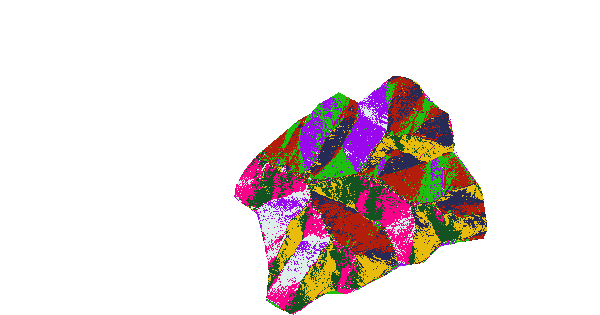

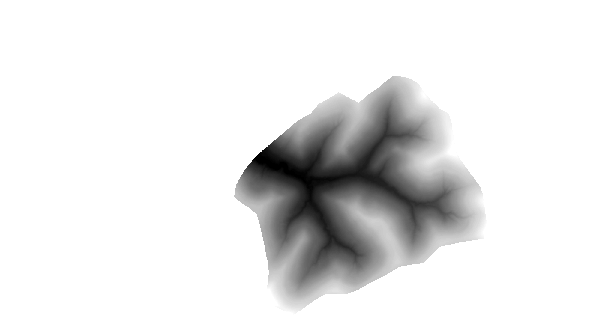

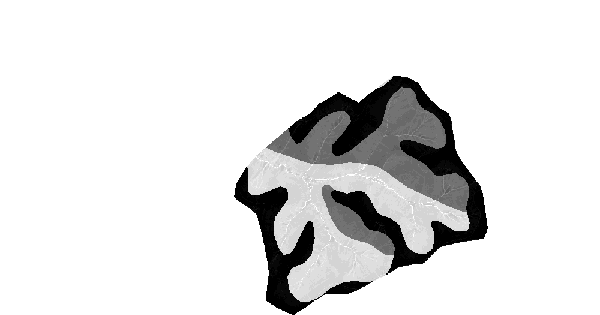

In [2]:
# Load in rasters 
FR_DEM = Raster('FR1meterDEM')
FR_HRU = Raster('FallingRockHRUs')
FR_Slope = Slope(FR_DEM)
FR_fill = Fill(FR_DEM)
FR_fdr = FlowDirection(FR_fill, "Normal") 
display(FR_fdr)
display(FR_fill)
display(FR_HRU)


### Step 3: Create a raster showing the class of downstream cells
In this step, we will return the HRU value of the cell that is immediately downstream of each cell in the watershed. 

In [13]:
# 

### Step 3b: Calculate this using the R kernel
I am doing this to see if there are any differences between the python and R code. 

In [7]:
library(sp)
library(raster)

FR.HRU <- raster('SpatialInputData/FallingRockHRUs.tif')
FR.fdr <- raster('SpatialInputData/fr_fdr')

HRU.matrix <- as.matrix(FR.HRU)
fdr.matrix <- as.matrix(FR.fdr)

fdr.downstream.matrix <- matrix(nrow=nrow(HRU.matrix),ncol=ncol(HRU.matrix))

for (i in 1:nrow(HRU.matrix)) {
  for (j in 1:ncol(HRU.matrix)) {
    if (is.na(fdr.matrix[i,j])) {
      fdr.downstream.matrix[i,j] <- NA
    } else {
      if (fdr.matrix[i,j]==1) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i,j+1]
      } else if (fdr.matrix[i,j]==2) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j+1]
      } else if (fdr.matrix[i,j]==4) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j]
      } else if (fdr.matrix[i,j]==8) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j-1]
      } else if (fdr.matrix[i,j]==16) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i,j-1]
      } else if (fdr.matrix[i,j]==32) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j-1]
      } else if (fdr.matrix[i,j]==64) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j]
      } else if (fdr.matrix[i,j]==128) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j+1]
      } else {
        fdr.downstream.matrix[i,j] <- NA
      }
    }
  }
}



NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Step 4: Calculate the weighting matrix which shows the number of cells from one HRU to contribute to downstream HRUs. 

In [8]:
downstream.weighting.matrix <- matrix(nrow=length(unique(FR.HRU)),ncol=length(unique(FR.HRU)))

for (i in 1:length(unique(FR.HRU))) {
  for (j in 1:length(unique(FR.HRU))) {
    downstream.weighting.matrix[i,j] <- length(which((HRU.matrix==unique(FR.HRU)[i])&(fdr.downstream.matrix==unique(FR.HRU)[j])))
  }
}

downstream.weighting.matrix <- matrix(nrow=length(unique(FR.HRU)),ncol=length(unique(FR.HRU)))

for (i in 1:length(unique(FR.HRU))) {
  for (j in 1:length(unique(FR.HRU))) {
    print(unique(FR.HRU)[i])
    downstream.weighting.matrix[i,j] <- length(which((HRU.matrix==unique(FR.HRU)[i])&(fdr.downstream.matrix==unique(FR.HRU)[j])))
  }
}
options("scipen"=100, "digits"=5)

rownames(downstream.weighting.matrix) <- unique(FR.HRU)
colnames(downstream.weighting.matrix) <- unique(FR.HRU)

weighting.matrix <- downstream.weighting.matrix/rowSums(downstream.weighting.matrix)

rownames(weighting.matrix) <- unique(FR.HRU)
colnames(weighting.matrix) <- unique(FR.HRU)


In [21]:
A <-  matrix(c(32,64,128,16,0,1,8,4,2),nrow=3,ncol=3,byrow=T)
i=2; j=2
A[i+1,j-1]

[1] 8